# Laboratorio di Simulazione Numerica: lezione 9

Elia Steve, 47122A

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math

### Esercizio 9.1

In questo esercizio dobbiamo trovare una soluzione al problema del commesso viaggiatore tramite ricerca casuale e un algoritmo genetico per $34$ città distribuite uniformemente 1. su una circonferenza e 2. in un quadrato. Ho scelto di misurare il costo di ciascun percorso con la metrica $L^{(1)}$, e cioè, se $(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$ è un percorso formato da $N$ città, 
$$
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|
$$

#### Ricerca casuale

La ricerca casuale consiste di iterazioni in cui si applicano a una popolazione di possibili percorsi i quattro operatori di mutazione (ognuno dei quali viene applicato con probabilità del $25\%$) descritti nel notebook di introduzione all'esercizio, e cioè permutazione di coppie (_pair permutation_), traslazione (_shift_), permutazone di intervalli e inversione (_inversion_). Ad ogni iterazione la soluzione con costo minore viene copiata nella popolazione dell'iterazione successiva senza modifiche, in modo che la singola iterazione non alzi la funzione di costo del miglior percorso. L'ottimizzazione termina 1. dopo un numero prefissato di iterazioni $n_\mathrm{max}$ (io ho usato $n_\mathrm{max}= 1000000$) oppure 2. dopo che non ci sono stati miglioramenti nella funzione di costo per un numero prefissato di interazioni $n'$ (io ho usato $n'=3000$).

#### Algoritmo genetico

L'algoritmo genetico consiste di iterazioni in cui si parte da una popolazione e ne viene generata una nuova con l'applicazione di un operatore di crossover: alcuni membri della nuova popolazione vengono poi mutati casualmente. Nei dettagli, questo processo consiste in:

* per ogni coppia di "figli" da generare selezionare due "genitori" in modo che i genitori con costo più basso abbiano più possibilità di riprodursi. Una volta che la popolazione è stata ordinata per costo crescente, l'indice degli individui selezionati è dato da $j= \mathrm{int}(M \times r^p)+1$, dove $M$ è il numero degli individui che partecipano alla selezione (un individuo scelto la prima volta non partecipa alla seconda selezione), $r\in[0, 1)$ un numero casuale generato con probabilità uniforme, e ho scelto di usare $p=5$.
* Applicare l'operatore di crossover descritto nel notebook di introduzione all'esercizio ai due genitori selezionati con probabilità del $90\%$: se non si applica l'operatore di crossover i genitori vengono copiati nella nuova popolazione senza modifiche.
* Una volta generati i figli, questi vengono mutati con gli stessi operatori di mutazione della ricerca casuale, ciascuno applicato con probabilità del $10\%$ (ad ogni figlio viene applicato al più un operatore di mutazione).

Le condizioni per terminare l'algoritmo genetico sono le stesse della ricerca casuale.

#### Commenti sull'implementazione

* Per la rappresentzione di percorsi e città e per le operazioni su di essi ho usato dovunque possibile la libreria armadillo e la STL.
* Per velocizzare il codice, ho precalcolato prima di applicare qualsisasi metodo di ottimizzazione le distenze relative di tutte le coppie di città che ho usato: il calcolo della funzione di costo per un percorso allora consiste semplicemente nella somma delle distanze per le città nel percorso.
* Le probabilitò di mutazione nel caso dell'algoritmo genetico sono relativamente alte, dato che ho osservato che una volta trovata una soluzione con costo ottimale questa si propaga tramite l'algoritmo di crossover agli altri individui in tempo relativamente breve, e che i miglioramenti a quel punto avvengono praticamente solo per mutazione.

#### Risultati nel caso del cerchio

Definisco funzioni per disegnare la soluzione:

In [213]:
def plot_network(G, title):
    """
    Plots the network.
    
    Args:
        G: Graph to plot
        title: title for the plot
    """
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
    plt.title(title)
    plt.show()

In [214]:
def create_graph(cities, path):
    """
    Given a list of cities and a path through them, creates a graph containing the path.

    Args:
        cities: list of cities
        path: path through the cities as a list of city labels (here numbers)
    """
    G = nx.DiGraph()
    for n, pos in enumerate(cities):
        G.add_node(n, pos=pos)
    
    for n1, n2 in zip(path, path[1:]):
        G.add_edge(n1, n2)

    return G

In [215]:
def compute_cycle_length(G, cycle):
    """
    Computes the length of the cycle in the graph. (Used for debugging)
    
    Args:
        G: graph
        cycle: cycle whose length is to be computed
    """
    length = 0
    for (id1, id2) in zip(cycle, cycle[1:]):
        pos1 = G.nodes[id1]['pos']
        pos2 = G.nodes[id2]['pos']
        distance = np.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2)
        length += distance
    return length

In [216]:
def draw_statistics(filenameMean, filenameBest, title, end_cutoff):
    """
    Draws plot of the fitness of the best individual and of the average fitness of the best half
    of the population as a function of the iteration.

    Args:
        filenameMean: name of file which contains the means of fitness of the best half of the population
        filenameBest: name of file which contains the fitness of the best individual of the population
        title: title of plot
        end_cutoff: number of final values to exclude from the graph (because there is no change in the
        best fitness anymore)
    """
    __, best = np.loadtxt(filenameBest, skiprows=1, unpack=True)
    __, mean, err = np.loadtxt(filenameMean, skiprows=1, unpack=True)

    #plt.errorbar(range(len(mean[:-2600])), mean[:-2600], yerr=err[:-2600])
    plt.plot(range(len(best[:-end_cutoff])), best[:-end_cutoff], label="Miglior individuo")
    plt.plot(range(len(mean[:-end_cutoff])), mean[:-end_cutoff], label="Media della migliore metà")
    plt.xlabel("Iterazione")
    plt.ylabel("Funzione costo")
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

Disegno i grafici per la ricerca casuale. Nel caso dei grafici per le medie della migliore metà della popolazione e del migliore individuo in funzione dell'iterazione ho mostrato solo le prime $50$ iterazioni dopo che c'è stata convergenza al risultato finale, invece delle $3000$ che ha fatto l'algoritmo.

In [217]:
cities = np.loadtxt("cities_circle.dat")

In [218]:
best_path = np.loadtxt("path_random_search_circle.dat", skiprows=1, dtype=int)
best_path = np.append(best_path, 0)

In [219]:
best_sol = create_graph(cities, best_path)

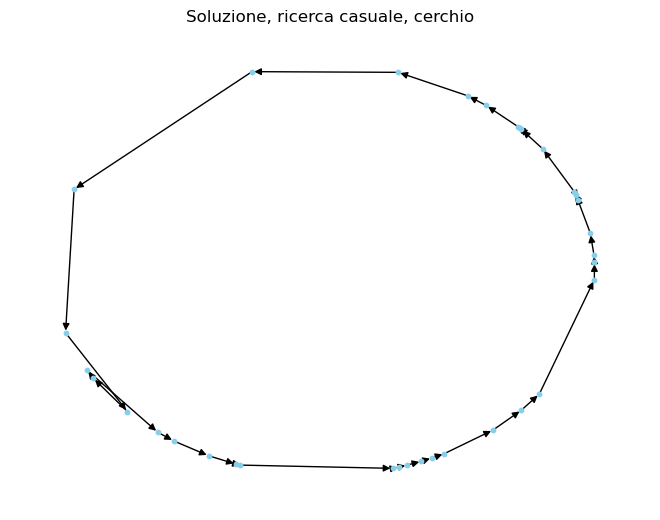

In [220]:
plot_network(best_sol, "Soluzione, ricerca casuale, cerchio")

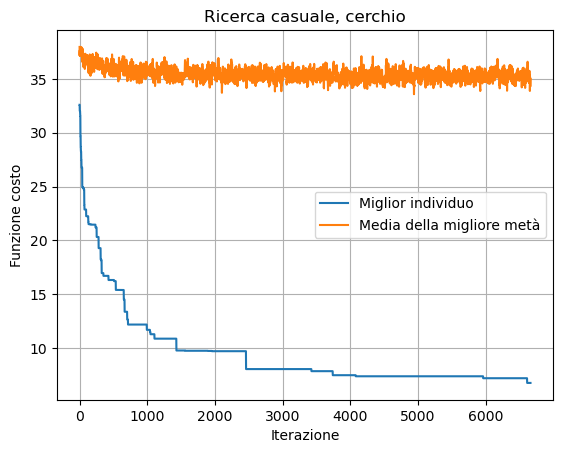

In [221]:
draw_statistics(
    "statistics_random_search_circle.dat",
    "prog_best_random_search_circle.dat",
    "Ricerca casuale, cerchio",
    2950
)

Osseviamo che la soluzione trovata è ragionevole ma probabilmente non è quella ottimale (vedi in basso a sinistra). La convergenza avviene in circa $6500$ iterazioni; la media della funzione costo della migliore metà degli individui si mantiene relativamene alta anche a fronte di un valore minimo molto inferiore, coerentemente con il fatto che la popolazione evolve in modo completamente casuale, e quindi la maggior parte degli individui non ha costo particolarmente basso.

Disegno i grafici nel caso dell'algoritmo genetico:

In [222]:
best_path = np.loadtxt("path_genetic_algo_circle.dat", skiprows=1, dtype=int)
best_path = np.append(best_path, 0)

In [223]:
best_sol = create_graph(cities, best_path)

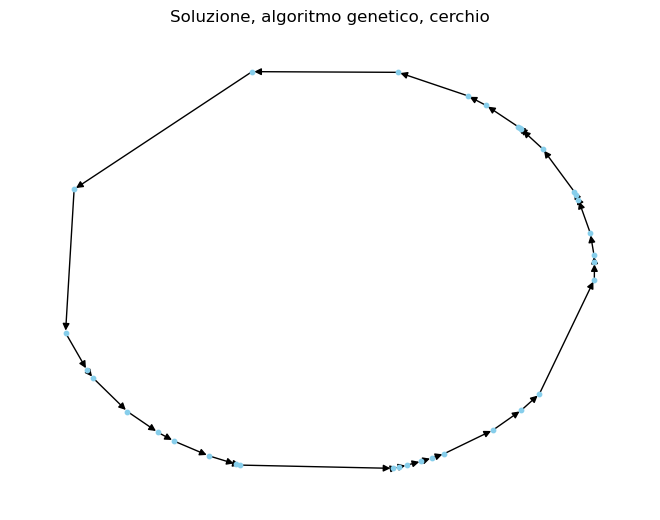

In [224]:
plot_network(best_sol, "Soluzione, algoritmo genetico, cerchio")

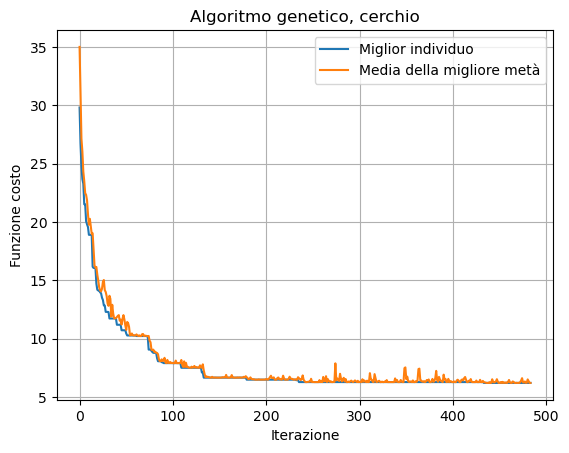

In [225]:
draw_statistics(
    "statistics_genetic_algo_circle.dat",
    "prog_best_genetic_algo_circle.dat",
    "Algoritmo genetico, cerchio",
    2950
)

Qui osserviamo che la soluzione è quella ottimale in cui ci si muove lungo il cerchio in una direzione: la convergenza è molto più veloce (circa $450$ iterazioni) e che la media della funzione costo della migliore metà degli individui segue molto da vicino il valore minimo, segno che i miglioramenti degli individui migliori si propagano in modo relativamente veloce anche con le probabilità di mutazione relativamente alte che ho usato.

#### Risultati nel caso del quadrato

Disegno i grafici nel caso della ricerca casuale:

In [226]:
cities = np.loadtxt("cities_square.dat")

In [227]:
best_path = np.loadtxt("path_random_search_square.dat", skiprows=1, dtype=int)
best_path = np.append(best_path, 0)

In [228]:
best_sol = create_graph(cities, best_path)

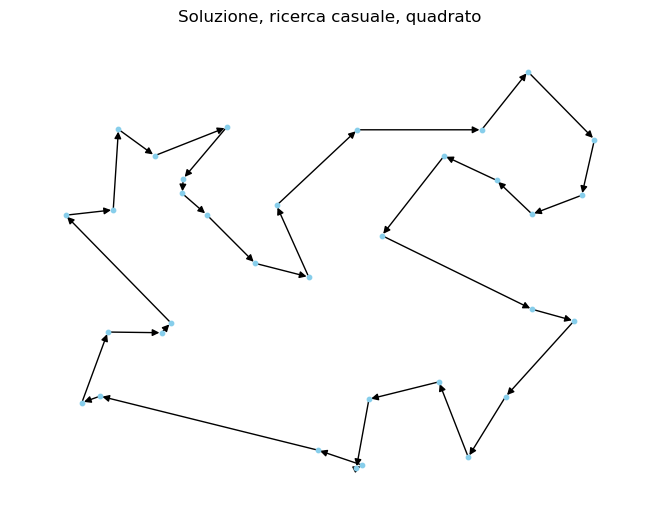

In [229]:
plot_network(best_sol, "Soluzione, ricerca casuale, quadrato")

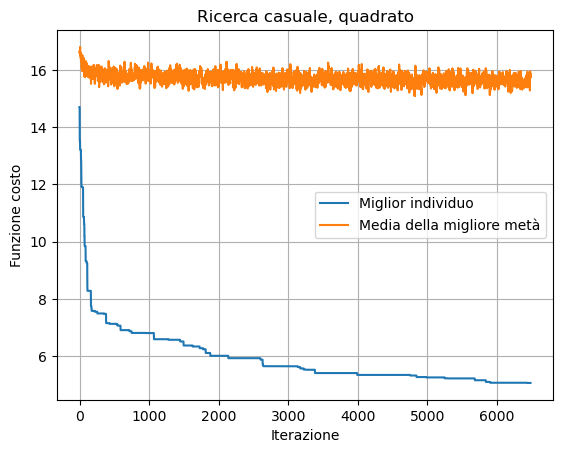

In [230]:
draw_statistics(
    "statistics_random_search_square.dat",
    "prog_best_random_search_square.dat",
    "Ricerca casuale, quadrato",
    2950
)

Vediamo risultati analoghi a quelli del caso del cerchio: la convergenza è a una soluzione ragionevole ma non ottimale (a posteriori, visto che l'algoritmo genetico converge a una migliore) e il valore medio della funzione costo si mantiene molto più grande di quello minimo.

Disegno i grafici nel caso dell'algoritmo genetico:

In [231]:
best_path = np.loadtxt("path_genetic_algo_square.dat", skiprows=1, dtype=int)
best_path = np.append(best_path, 0)

In [232]:
best_sol = create_graph(cities, best_path)

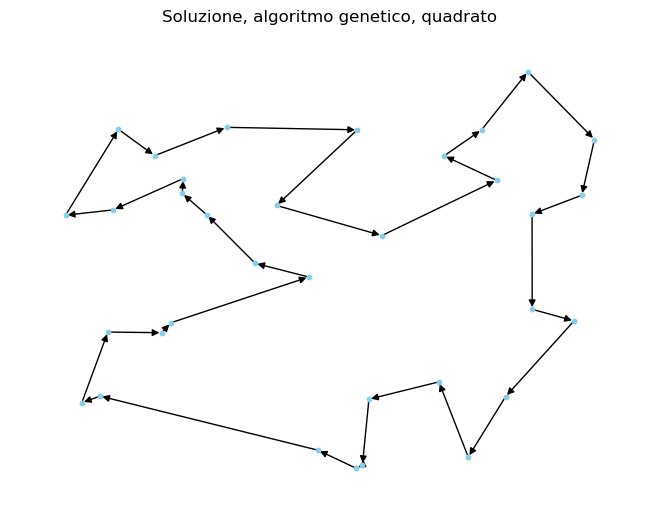

In [233]:
plot_network(best_sol, "Soluzione, algoritmo genetico, quadrato")

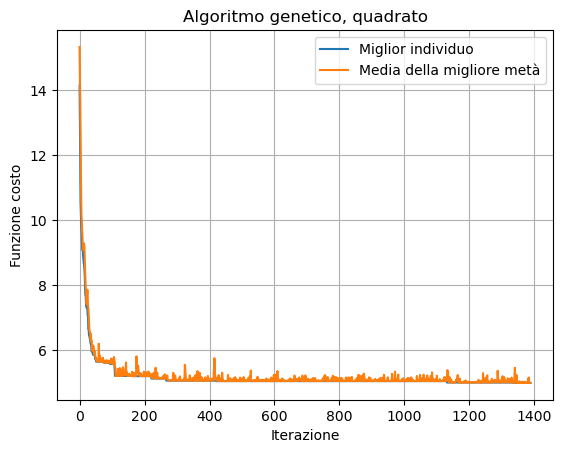

In [234]:
draw_statistics("statistics_genetic_algo_square.dat", "prog_best_genetic_algo_square.dat", "Algoritmo genetico, quadrato", 2950)

Anche qui i risultati sono analoghi al caso del cerchio: la soluzione è migliore che nel caso della ricerca casuale, la convergenza più veloce e la media della funzione costo della migliore metà della popolazione segue relativaente bene il valore minimi.